## Author: Samuel Hickey

### Word-level (notes and chords treated as singular words) Music Generating RNN
### Version 3.0: Next Word Prediction with context targets

In version 1, we followed the Tensorflow tutorial from Magenta to attempt to generate Music using RNNs.

In version 2, we will diverge from the approach of V1 and attempt to generate notes in a manner similar to generating sentences in NLP.
We will train the model using next word prediction. Our vocabulary will consist of all notes and note combinations found in the Maestro v2 dataset (~12000 different combinations)

Here in 3.0, we will...

- remove one-hot encoding of the targets
- instead of only providing the next note as a target use the next sequence.
- refactor the model structure to a class
- modify the generation process to match the new structure

## Imports

In [1]:
import collections
import glob
import keras
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf
gpu = tf.config.list_physical_devices('GPU')[0]
tf.config.experimental.set_memory_growth(gpu, False)
import warnings

from numba import jit
from keras.layers import (BatchNormalization, Bidirectional, CategoryEncoding, Embedding, Dense, Dropout, LSTM)
from keras.utils import timeseries_dataset_from_array
from keras.preprocessing.text import Tokenizer
from utilities.DatasetUtils import (midi_to_notes, plot_piano_roll)

warnings.filterwarnings("ignore")

SEQ_LEN = 256
MODEL_PATH = 'models/V3.0/'

### Select Dataset

In [2]:
data_dir = pathlib.Path('data/maestro-v2.0.0')
filenames = glob.glob(str(data_dir/'*/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1282


### Extract the Notes

For each song, we round the start times of each note to the nearest one-thousandth of a second and consider any notes with the same start time to be a chord i.e. a new term in our vocabulary. Each step contains at least one key and as many as seven keys.

In [3]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
	instrument = pretty_midi.PrettyMIDI(midi_file).instruments[0]
	notes = collections.defaultdict(list)
	notes['pitch'].append('[START]')
	notes['start'].append(0)
	for note in sorted(instrument.notes, key=lambda note: note.start):
		notes['pitch'].append(pretty_midi.note_number_to_name(note.pitch))
		notes['start'].append(round(note.start, 3))
	notes['pitch'].append('[END]')
	notes['start'].append(round(note.start, 2) + 3)

	result = pd.DataFrame({name: np.array(value) for name, value in notes.items()}) \
		.groupby('start') \
		.agg({'pitch': sorted}) \
		.reset_index() \
		.pitch.str.join(',') \
		.to_frame()
	return result

# Load the files
num_files = 25 # len(filenames)
notes = []
for f in np.random.choice(filenames, num_files):
    df = midi_to_notes(f)
    notes.append(df)
notes = pd.concat(notes).pitch

### Save Notes, Vocabulary, Character Indices

In [4]:
# Create a vocabulary, id-lookup, and note-lookup
vocab = np.unique(notes.to_numpy())
ids_from_notes = {v:k for k, v in enumerate(vocab)}
notes_from_ids = {k:v for k, v in enumerate(vocab)}
# np.save(
#     pathlib.Path('data/preprocessed/vocab_ids_notes.npy'),
#     [vocab, ids_from_notes, notes_from_ids],
#     allow_pickle=True
# )
# Integer encode the notes
notes = notes.map(lambda note: ids_from_notes[note]) \
	.reset_index() \
	.pitch
# np.save(
#     pathlib.Path('data/preprocessed/notes.npy'),
#     notes,
#     allow_pickle=True
# )

### Load Notes, Vocabulary, Note Indices

The vocabulary and note indices were created using ALL of the available midi files in the Maestro V2 dataset.

In [5]:
# vocab, ids_from_chars, chars_from_ids = np.load(
# 	'data/preprocessed/vocab_ids_notes.npy',
# 	allow_pickle=True
# )
# notes = np.load('data/preprocessed/notes.npy', allow_pickle=True)

### Create Dataset

Here we are using time_series_dataset_from_array to create batches of sequences that have a length of SEQ_LEN. Next, we map each batch over the split_input_target function to create an input and a target of shape (batch_size, SEQ_LEN-1). 

It is important to our understanding that we realize time_series_dataset_from_array will take a sequence of events [x1, x2, ...,  x_n] and produce a tensor of sequences: 

[[x1, x2, ..., x_seq_len], 
<br>[x_seq_len, x_seq_len+1, ..., x_seq_len*2],
<br>[  ...  ]
<br>[x_n-seq_len, x_n+1-seq_len, ..., x_n]]

Where [x_n-seq_len, x_n+1-seq_len, ..., x_n]] is the last sequence in the batch.

In [6]:
batch_size = 64
# buffer_size = 10000
# removed .shuffle(buffer_size) \ after ".map(split) \"

split = lambda seq: (seq[:, :-1], seq[:, 1:])
def reshape(x, y):
    x, y = tf.squeeze(x), tf.squeeze(y)
    x.set_shape((batch_size, SEQ_LEN))
    y.set_shape((batch_size, SEQ_LEN))
    return x, y

dataset = timeseries_dataset_from_array(
    data=notes,
    targets=None,
    sequence_length=SEQ_LEN+1,
    batch_size=1
) \
    .map(split) \
    .batch(batch_size, drop_remainder=True) \
    .map(reshape) \
    .cache() \
    .prefetch(tf.data.AUTOTUNE)

# tf.data.experimental.save(dataset, 'data/preprocessed/1282_notes')

### Model Definition and Initialization

In [7]:
vocab_size = len(vocab)
embedding_dim = 256
units = 256

class MusicGenRnnV3(keras.Model):
    def __init__(self, vocab_size, embedding_dim, units):
        super().__init__(self)
        self.embedding = Embedding(vocab_size, embedding_dim)
        self.lstm = Bidirectional(LSTM(units//2, return_sequences=True, return_state=True))
        self.out = Dense(vocab_size)
    
    def call(self, inputs, states=None, return_states=False, training=False):
        x = inputs
        x = self.embedding(x, training=training)
        x, fwd_h, fwd_c, bkwd_h, bkwd_c = self.lstm(x, initial_state=states, training=training)
        x = self.out(x, training=training)

        if return_states:
            return (x, [fwd_h, fwd_c, bkwd_h, bkwd_c])
        else:
            return x

model = MusicGenRnnV3(vocab_size, embedding_dim, units)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipvalue=.5)
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss)

### Training

In [8]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=MODEL_PATH+f'generator/seq_len_{SEQ_LEN}/checkpoints/'+'ckpt_{epoch}',
        save_weights_only=True),
    keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]
history = model.fit(dataset, epochs=50, callbacks=callbacks)
model.save(pathlib.Path(MODEL_PATH+f'generator/seq_len_{SEQ_LEN}/model/'))

Epoch 1/50
1502/1502 [==============================] - 103s 66ms/step - loss: 1.8270
Epoch 2/50
1502/1502 [==============================] - 99s 66ms/step - loss: 0.2440
Epoch 3/50
1502/1502 [==============================] - 101s 67ms/step - loss: 0.1000
Epoch 4/50
1502/1502 [==============================] - 101s 67ms/step - loss: 0.0411
Epoch 5/50
1502/1502 [==============================] - 100s 66ms/step - loss: 0.0221
Epoch 6/50
1502/1502 [==============================] - 99s 66ms/step - loss: 0.0166
Epoch 7/50
1502/1502 [==============================] - 100s 66ms/step - loss: 0.0147
Epoch 8/50
1502/1502 [==============================] - 100s 66ms/step - loss: 0.0140
Epoch 9/50
1502/1502 [==============================] - 100s 67ms/step - loss: 0.0135
Epoch 10/50
1502/1502 [==============================] - 99s 66ms/step - loss: 0.0131
Epoch 11/50
1502/1502 [==============================] - 98s 65ms/step - loss: 0.0128
Epoch 12/50
1502/1502 [==============================] -

INFO:tensorflow:Assets written to: models\V3.0\generator\seq_len_256\model\assets


INFO:tensorflow:Assets written to: models\V3.0\generator\seq_len_256\model\assets


# Generation

### Create OneStep Model

In [12]:
class OneStep(tf.keras.Model):
  def __init__(self, model, vocabulary, temperature=0.1):
    super().__init__(self)
    self.temperature = temperature
    self.model = model
    self.ids_from_notes = tf.keras.layers.StringLookup(vocabulary=list(vocabulary), mask_token=None)
    self.notes_from_ids = tf.keras.layers.StringLookup(vocabulary=list(vocabulary), mask_token=None, invert=True)
    self.ids_from_notes.compile(run_eagerly=True)
  @tf.function
  def call(self, inputs, states=None):
    # predicted_logits.shape = [1, SEQ_LEN, vocab_size]
    input_ids = self.ids_from_notes(tf.expand_dims(inputs, axis=0))
    predicted_logits, states = self.model(input_ids, states=states, return_states=True)
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits / self.temperature

    # Choose a random sample from top 5% of logits
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    prediction =self.notes_from_ids(predicted_ids)

    # Return the int_id of note and model state.
    return prediction, states

# Declare, Initialize, and Save Step Model
one_step_model = OneStep(model, vocab)
one_step_model(
  notes.map(lambda note: notes_from_ids[note]).to_numpy()[:SEQ_LEN]
)
one_step_model.save(pathlib.Path(f'models/V3.0/step/seq_len_{SEQ_LEN}'))

INFO:tensorflow:Assets written to: models\V3.0\step\seq_len_256\assets


INFO:tensorflow:Assets written to: models\V3.0\step\seq_len_256\assets


### Generate new notes

In [21]:
# Get indices for a random input sequence from notes
start = np.random.choice([i for i in range(len(notes)-SEQ_LEN-1)])
end = start + SEQ_LEN

# Set initial states, sequence, and results
states = None
next_note = notes \
  .map(lambda note: notes_from_ids[note]) \
  .to_numpy()[start:end]
results = list(next_note)

steps = 256
for n in range(steps):
  pred_note, states = one_step_model(next_note, states=states)
  pred_note = pred_note.numpy()[0].decode('utf-8') 
  next_note = np.append(next_note[1::], pred_note)
  results.append(pred_note)
print(
  'Input:', results[:SEQ_LEN], 
  '\n\nResults', results[SEQ_LEN:]
)

Input: ['C4', 'G5', 'E5', 'C4', 'D6', 'D5', 'G3', 'E3', 'E6', 'E5', 'G2', 'A2', 'G2', 'F5', 'F6', 'G5', 'D3', 'F3', 'B3', 'G5', 'B3', 'D5', 'D6', 'C6', 'F3', 'D3', 'B5', 'B4', 'G2', 'G2', 'C5', 'C6', 'E3', 'G5', 'G3', 'E5', 'C4', 'E5', 'G5', 'C4', 'G5', 'G4', 'G3', 'E3', 'G2', 'G4', 'G5', 'G2', 'G4', 'G5', 'D3', 'F3', 'F5', 'D5', 'B3', 'D5', 'F5', 'B3', 'A5', 'A4', 'F3', 'D3', 'B5', 'B4', 'G2', 'G2', 'C5', 'C6', 'E3', 'G3', 'E5,G5', 'C4', 'G5', 'E5', 'C4', 'D6', 'D5', 'G3', 'E3', 'E6', 'E5', 'G2', 'G2', 'G6', 'B5', 'G5', 'D3', 'F3', 'F6', 'F5', 'B3', 'B3', 'D6', 'D5', 'F3', 'D3', 'B5', 'B4', 'G2', 'C4', 'C5,C6,E5', 'E3', 'C3', 'D3', 'E4', 'E5', 'E3', 'E5', 'E4,E6', 'E3', 'E6', 'E4', 'E7', 'C#7', 'E3', 'E6', 'F3', 'E4', 'F6', 'C#4', 'E3', 'C#3', 'E5', 'E5', 'E4', 'D4', 'F3', 'D3', 'F5', 'F4', 'F4', 'F4', 'E4', 'F4', 'E4', 'F4', 'E4', 'F4', 'B3', 'B2', 'F3', 'F4', 'F5', 'F4', 'E4', 'F4', 'E4', 'F4', 'F4', 'E4', 'F5', 'F4', 'G#3', 'F4', 'F5,G#2', 'E3', 'E4', 'E5', 'E3', 'E5', 'E4', 'E6', 

### Cosine Similarity

In [22]:
orig = np.vectorize(lambda x: ids_from_notes[x])(results[:SEQ_LEN])
gen = np.vectorize(lambda x: ids_from_notes[x])(results[SEQ_LEN:SEQ_LEN*2])

cos_sim = np.dot(gen, orig) \
    / (np.linalg.norm(gen) * np.linalg.norm(orig))
cos_sim

0.9117033782331208

### Extract Input & Target Sequence to DataFrame

In [23]:
def notes_to_df(input: list) -> pd.DataFrame:
    '''
        Params:
            input: list[str] - contains a sequence of notes, chords
                should be a single string with each key separated by a comma
        Returns:
            pd.DataFrame(cols=['pitch', 'start', 'end', 'duration', 'step'])
    '''
    notes = pd.DataFrame(columns=['pitch', 'start', 'end', 'duration', 'step'])
    temp, j = (0.2, 0.5)
    for i in range(len(input)):
        if input[i] != '[END]':
            j+= temp
            notes.loc[i] = (input[i].split(','), j, j+.1, .1, temp)
        else:
            break
    return notes.explode('pitch')
    
orig_df = notes_to_df(results[1:SEQ_LEN])
notes_df = notes_to_df(results[SEQ_LEN:])

### Extract Instrument

In [24]:
file = pretty_midi.PrettyMIDI(filenames[0])
instrument_name = pretty_midi.program_to_instrument_name(file.instruments[0].program)

### Save MIDI files

In [25]:
def df_to_midi(
        notes: pd.DataFrame,
        out_file: str, 
        instrument_name: str,
        velocity: int = 90,  # note loudness
) -> pretty_midi.PrettyMIDI:
    file = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(
        program=pretty_midi.instrument_name_to_program(
        instrument_name))
    for i, note in notes.iterrows():
        note = pretty_midi.Note(
            velocity=velocity,
            pitch=int(pretty_midi.note_name_to_number(note['pitch'])),
            start=note['start'],
            end=note['end'],
        )
        instrument.notes.append(note)
    file.instruments.append(instrument)
    file.write(out_file)

df_to_midi(orig_df, 'input_seq.midi', instrument_name)
df_to_midi(notes_df, f'seq_len_{SEQ_LEN}_steps_{steps}.midi', instrument_name)

### Prep and Plot the DataFrames

In [26]:
orig_df.pitch = orig_df.pitch.map(pretty_midi.note_name_to_number)
notes_df.pitch = notes_df.pitch.map(pretty_midi.note_name_to_number)

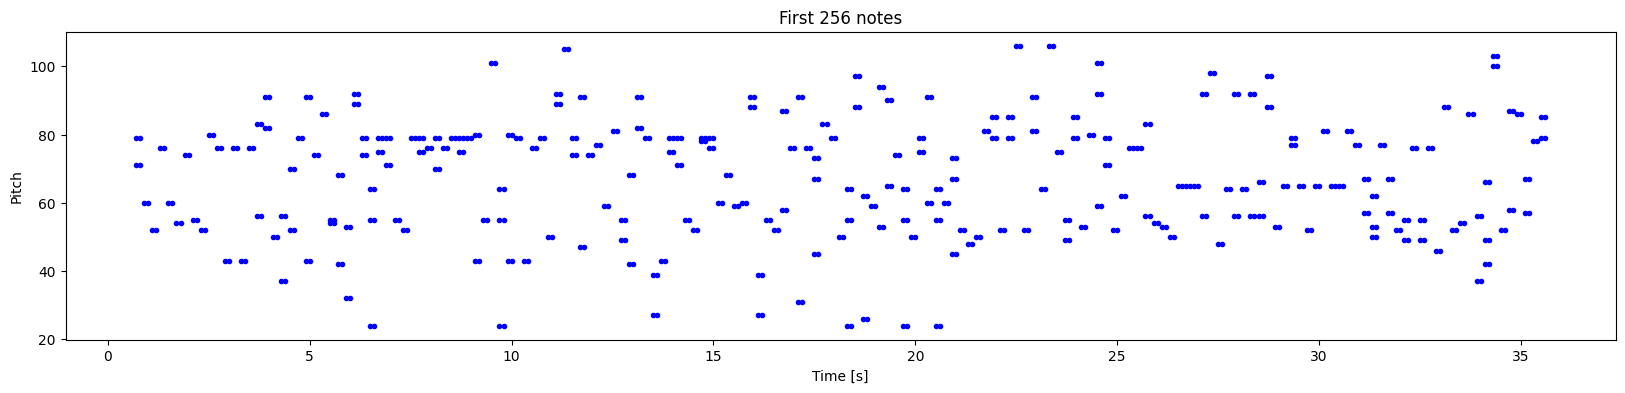

In [27]:
plot_piano_roll(notes_df, 256)

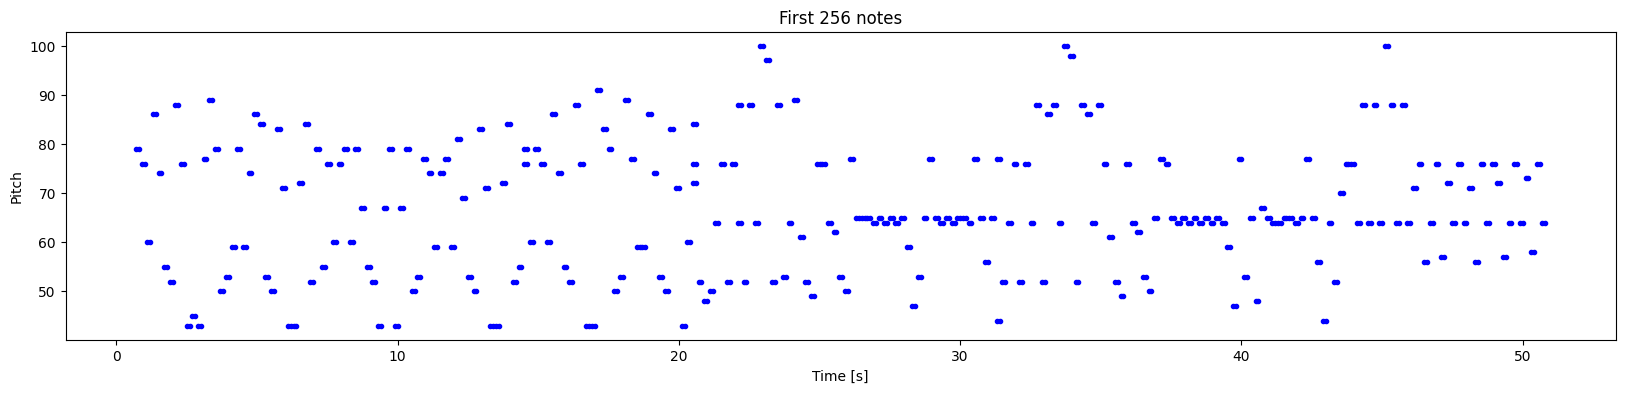

In [28]:
plot_piano_roll(orig_df, 256)